In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import talib
import traceback

%matplotlib inline

Using plaidml.keras.backend backend.


In [2]:
dateparse = lambda x,y: pd.datetime.strptime(x+' '+y, '%m/%d/%Y %H:%M')
df = pd.read_csv('data.txt',parse_dates=[[0,1]],index_col=0,skiprows=0,date_parser=dateparse)
df.index.rename('Time',inplace=True)
df.columns = ['open','high','low','close','volume']

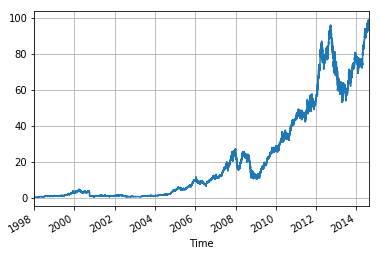

In [3]:
df['close'].plot()
plt.grid()

In [5]:
def create_synth_series(x,y,mult=1):    
    op = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    cl = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    hi = pd.Series(y+1+mult*np.abs(np.random.randn(len(df))),index=df.index)
    lo = pd.Series(y-1-mult*np.abs(np.random.randn(len(df))),index=df.index)
    dfs = pd.DataFrame([op,hi,lo,cl]).T
    dfs.index.rename('Time',inplace=True)
    dfs.columns = ['open','high','low','close']
    return dfs

In [6]:
ldf = len(df)
mid= int(ldf/2)
x = np.arange(len(df))
y = np.zeros(ldf)
y[mid:] = 0.01*x[:mid]+100
y[:mid] = 10*np.sin(0.01*x[:mid])+100#+y[mid-1]
dft = create_synth_series(x,y,mult=0.00)

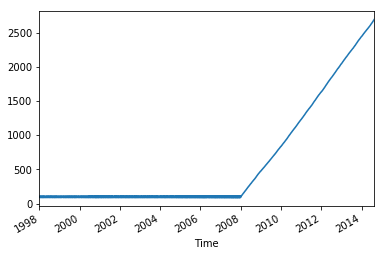

In [7]:
dft['close'].plot()

In [8]:
class ExperienceReplay(object):
    '''This class gathers and delivers the experience'''
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

In [9]:
class Game(object):
    '''This is the game. It starts, then takes an action (buy or sell) at some point and finally the reverse
    action, at which point it is game over. This is where the reward is given. The state consists of a vector
    with different bar sizes for OLHC. They are just concatenated. 
    lkbk: determines how many bars to use - larger lkbk - bigger state
    '''
    def __init__(self, df, lkbk=20, max_game_len=1000, run_mode='sequential', init_idx=None):
        self.df = df
        self.lkbk = lkbk
        self.max_game_len = max_game_len
        
        self.is_over = False
        self.reward = 0
        self.run_mode =  run_mode
        self.pnl_sum = 0
        if run_mode == 'sequential' and init_idx == None:
            print('------No init_idx set for "sequential": stopping------')
            return
        else:
            self.init_idx = init_idx
        self.reset()
        
    def _update_state(self, action):
        
        '''Here we update our state'''
        self.curr_idx += 1
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_price = self.df['close'][self.curr_idx]
        self.pnl = (-self.entry + self.curr_price)*self.position/self.entry
        self._assemble_state()
        _k = list(map(float,str(self.curr_time.time()).split(':')[:2]))
        self._time_of_day = (_k[0]*60 + _k[1])/(24*60) 
        self._day_of_week  = self.curr_time.weekday()/6
        self.norm_epoch = (df.index[self.curr_idx]-df.index[0]).total_seconds()/self.t_in_secs
        
        '''This is where we define our policy and update our position'''
        if action == 0:  
            pass
        
        elif action == 2:
            if self.position == -1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx
   
            elif self.position == 0:
                self.position = 1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else: 
                pass
            
        elif action == 1:
            if self.position == 1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx

            elif self.position == 0:
                self.position = -1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else:
                pass
        
    
    def _assemble_state(self):
        '''Here we can add other things such as indicators and times'''
        self._get_last_N_timebars()
        bars = [self.last5m,self.last1h,self.last1d]
        state = []
        candles = {j:{k:np.array([]) for k in ['open','high','low','close']} for j in range(len(bars))}
        for j,bar in enumerate(bars):
            for col in ['open','high','low','close']:
                candles[j][col] = np.asarray(bar[col])
                state += (list(np.asarray(bar[col]))[-10:])

        
        self.state = np.array([])
        self.state = np.append(self.state,state)
        self.state = np.append(self.state,self.position)
        np.append(self.state,np.sign(self.pnl_sum))
        self.state = np.append(self.state,self._time_of_day)
        self.state = np.append(self.state,self._day_of_week)
        
        for c in candles:
            try:
                sma1 = talib.SMA(candles[c]['close'],self.lkbk-1)[-1]
                sma2 = talib.SMA(candles[c]['close'],self.lkbk-8)[-1]
                self.state = np.append(self.state,(sma1-sma2)/sma2)
                self.state = np.append(self.state,sma1)
                self.state = np.append(self.state,talib.RSI(candles[c]['close'],self.lkbk-1)[-1])
                self.state = np.append(self.state,talib.MOM(candles[c]['close'],self.lkbk-1)[-1])
                #self.state = np.append(self.state,talib.MACD(candles[c]['close'],fastperiod=11, slowperiod=22, signalperiod=9)[0][0])
                self.state = np.append(self.state,talib.BOP(candles[c]['open'],
                                               candles[c]['high'],
                                               candles[c]['low'],
                                               candles[c]['close'])[-1])
                #self.state = np.append(self.state,talib.ADXR(candles[c]['high'],
                #                               candles[c]['low'],
                #                               candles[c]['close'],
                #                               self.lkbk-3)[-1]) 
                #self.state = np.append(self.state,talib.STOCH(candles[c]['high'],
                #                               candles[c]['low'],
                #                               candles[c]['close'],5,3,0,3,0)[-1][0])
                self.state = np.append(self.state,talib.AROONOSC(candles[c]['high'],
                                               candles[c]['low'],
                                               self.lkbk-3)[-1])
            except: print(traceback.format_exc())
        #print('-->',self.state)
        self.state = (np.array(self.state)-np.mean(self.state))/np.std(self.state)
        


        
        
    def _get_last_N_timebars(self):
        '''The lengths of the time windows are currently hardcoded.'''
        # TODO: find better way to calculate window lengths
        wdw5m = 9
        wdw1h = np.ceil(self.lkbk*15/24.)
        wdw1d = np.ceil(self.lkbk*15)
        
        self.last5m = self.df[self.curr_time-timedelta(wdw5m):self.curr_time].iloc[-self.lkbk:]
        self.last1h = self.bars1h[self.curr_time-timedelta(wdw1h):self.curr_time].iloc[-self.lkbk:]
        self.last1d = self.bars1d[self.curr_time-timedelta(wdw1d):self.curr_time].iloc[-self.lkbk:]
        
        '''Making sure that window lengths are sufficient'''
        try:
            assert(len(self.last5m)==self.lkbk)
            assert(len(self.last1h)==self.lkbk)
            assert(len(self.last1d)==self.lkbk)
        except:
            print('****Window length too short****')
            print(len(self.last5m),len(self.last1h),len(self.last1d))
            if self.run_mode == 'sequential':
                self.init_idx = self.curr_idx
                self.reset()
            else:
                self.reset()


    def _get_reward(self):
        if self.position == 1 and self.is_over:
            pnl = (self.curr_price - self.entry)/self.entry
            self.reward = np.sign(pnl)#-(self.curr_idx - self.start_idx)/1000.
        elif self.position == -1 and self.is_over:
            pnl = (-self.curr_price + self.entry)/self.entry
            self.reward = np.sign(pnl)#-(self.curr_idx - self.start_idx)/1000.
        #print('entry:',self.entry,'exit:',self.curr_price,'pos:',self.position,'pnl:',pnl,self.reward)
        return self.reward
            
    def observe(self):
        return np.array([self.state])

    def act(self, action):
        self._update_state(action)
        reward = self.reward
        game_over = self.is_over
        return self.observe(), reward, game_over

    def reset(self):
        self.pnl = 0
        self.entry = 0
        self._time_of_day = 0
        self._day_of_week = 0
        
        if self.run_mode == 'random':
            self.curr_idx = np.random.randint(0,len(df)-3000)
            
        elif self.run_mode == 'sequential':
            self.curr_idx = self.init_idx
            
        self.t_in_secs = (df.index[-1]-df.index[0]).total_seconds()
        self.start_idx = self.curr_idx
        self.curr_time = self.df.index[self.curr_idx]
        self.bars1h = df['close'].resample('1H',label='right',closed='right').ohlc().dropna()
        self.bars1d = df['close'].resample('1D',label='right',closed='right').ohlc().dropna()
        self._get_last_N_timebars()
        self.state = []
        self.position = 0
        self._update_state(0)

In [13]:
def run(df,fname):
    # parameters
    epsilon_0 = .001
    num_actions = 3 
    epoch = 11500
    max_memory = 10000
    
    batch_size = 500
    lkbk = 25
    START_IDX = 3000

    env = Game(df, lkbk=lkbk, max_game_len=1000,init_idx=START_IDX,run_mode='sequential')
    hidden_size = len(env.state)*2
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(len(env.state),), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.005), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow
    #model.load_weights("indicator_model.h5")

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    loss_cnt = 0
    wins = []
    losses = []
    pnls = []
    for e in range(epoch):
        epsilon = epsilon_0**(np.log10(e))
        env = Game(df, lkbk=lkbk, max_game_len=1000,init_idx=env.curr_idx,run_mode='sequential')
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        cnt = 0
        while not game_over:
            cnt += 1
            input_tm1 = input_t
            # get next action

            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)[0]
                if env.position == 0:
                    if action == 2:
                        exit_action = 1
                    elif action == 1:
                        exit_action = 2
                #if env.position and action == exit_action:
                #    print('***random exit***',env.position)
                #elif not env.position and action:
                #    print('***random entry***',env.position)
                    
            elif env.position == 0:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])
                if action:
                    #print(cnt)
                    exit_action = np.argmin(q[0][1:])+1
                
            elif cnt > 500:
                #print('***Time Exit***')
                action = exit_action
                
            elif env.position:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward > 0:
                win_cnt += 1
            elif reward < 0:
                loss_cnt += 1

            # store experience
            if action or len(exp_replay.memory)<20 or np.random.rand() < 0.1:
                exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
            env.pnl_sum = sum(pnls)

            zz = model.train_on_batch(inputs, targets)
            loss += zz
        prt_str = ("Epoch {:03d} | Loss {:.2f} | pos {} | len {} | pnl {:.2f}% @ {:.2f}% | eps {:,.4f} | {}".format(e, 
                                                                                      loss, 
                                                                                      env.position, 
                                                                                      env.trade_len,
                                                                                      sum(pnls)*100,
                                                                                      env.pnl*100,
                                                                                      epsilon,
                                                                                      env.curr_time))
        print(prt_str)
        fid = open(fname,'a')
        fid.write(prt_str+'\n')
        fid.close()
        pnls.append(env.pnl)
        if not e%10:
            print('----saving weights-----')
            model.save_weights("indicator_model.h5", overwrite=True)


In [ ]:
fname = 'output1.dat'
fid = open(fname,'w')
fid.close()
run(df,fname)

/home/sharavsambuu/src/quantcon2018-rl/env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/sharavsambuu/src/quantcon2018-rl/env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


Epoch 000 | Loss 1.86 | pos -1 | len 1 | pnl 0.00% @ -0.27% | eps inf | 1998-02-27 10:30:00
----saving weights-----
Epoch 001 | Loss 2.81 | pos -1 | len 1 | pnl -0.27% @ -0.26% | eps 1.0000 | 1998-02-27 10:45:00
Epoch 002 | Loss 0.26 | pos -1 | len 12 | pnl -0.53% @ -0.28% | eps 0.1250 | 1998-02-27 12:00:00
Epoch 003 | Loss 0.24 | pos -1 | len 153 | pnl -0.81% @ 3.82% | eps 0.0370 | 1998-03-03 11:55:00
